In [58]:
import pyprind
import pandas as pd
import os
import numpy as np

In [59]:
np.random.seed(0)

In [60]:
df = pd.read_excel('/Users/ramo/Dropbox/Stats/multiple-mets/data/labeled/final_dataset.xlsx')
df.head(2)

,Group_x,Report
1805,2,Type: MRI BRAIN W/WO CONTRAST\nDate/Time: ...
1806,3,PROCEDURE: MR Brain WWO Contrast HISTORY: 48-...


In [61]:
df.rename(columns={'Group_x': 'Group'}, inplace=True)

In [62]:
# Drop category 2 (not sure), and 3 (not met)
df = df[(df['Group'] == 1) | (df['Group'] == 0)]

In [99]:
print df.head()
print len(df)

      Group                                       clean_report
1807      0  procedure mr brain without and with contrast c...
1808      1  type mri brain w wo contrastdate time  14:20ex...
1809      1  type mr brain w and w ocont date time  19:05ex...
1810      1  procedure mr brain wwo contrast history  75 ye...
1811      0  type fmri brain by techdate time  08:32exam co...
1479


In [64]:
df['Report'][1]

u'PROCEDURE: MR Brain W Contrast   HISTORY:  Mass within the left superior frontal gyrus.  Also left temporoparietal meningioma.  Preoperative exam.  TECHNIQUE: Limited axial 3D MP-RAGE postcontrast with coronal and sagittal reformatted images images of the brain, for preoperative localization.  COMPARISON: MRI brain with and without contrast on June 6, 2009.  FINDINGS: As recently noted, there is a heterogeneously enhancing mass centered in the left superior frontal gyrus.  The mass measures 1.3-cm transverse by 1.6-cm AP by 1.4 cm CC (series 4 image 148 chemistry 100 image 39), not significant changed from recent measurements of 1.4 x 1.6 x 1.4 cm, respectively.  Inferior to the well-defined enhancing lesion, there is again noted to be a less well-defined area of increased signal, which demonstrated intrinsic T1 hyperintensity on the precontrast images of the June 6, 2009 exam.  The previously questioned superimposed enhancement, which is now difficult to assess given the lack of pre

## Cleaning text data

In [65]:
import re

In [66]:
def preprocessor(text):
    # Remove newlines
    text = text.replace(r'\n', '')
    
    # Remove date
    date_pattern = r'[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{2,}'
    text = re.sub(date_pattern, '', text.lower())
    
    # Remove whitespace
    text = ' '.join(text.split())
    
    # Remove punctution, keep decimal points
    text = re.sub(r'[\W]+(?!\d)', ' ', text)
    
    # Remove the signature at the end of the report              
    
    if text.find(' i the teaching physician') != -1:
        body_pattern = re.compile(r'(.*) (?=i the teaching physician)')
        matched_text = body_pattern.search(text).group(1)
        
    elif text.find(' end of impression') != -1:
        body_pattern = re.compile(r'(.*) (?=end of impression)')
        matched_text = body_pattern.search(text).group(1)
    
    elif text.find(' radiologists signatures') != -1:
        body_pattern = re.compile(r'(.*) (?=radiologists signatures)')
        
        matched_text = body_pattern.search(text).group(1)
    
    else:
        matched_text = text
        
    return matched_text

In [67]:
# TODO: Add named entity recognition to reduce report noise

In [68]:
df['clean_report'] = df['Report'].apply(preprocessor)

In [69]:
df.to_csv('train_dataOA11.19.16.csv', columns=['clean_report', 'Group'])

In [70]:
del df['Report']

In [71]:
df.head(2)

,Group,clean_report
1807,0,procedure mr brain without and with contrast c...
1808,1,type mri brain w wo contrastdate time 14:20ex...


## Tokinizing, stemming, stop words

In [72]:
def tokenizer(text):
    return text.split()

In [73]:
from nltk.stem.porter import PorterStemmer

In [74]:
porter = PorterStemmer()

In [75]:
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [76]:
# TODO: porter2 and lancaster stemming

In [77]:
from nltk.corpus import stopwords

In [78]:
stop = stopwords.words('english')

In [79]:
stop_modified = [w for w in stop if w not in ['no', 'not']]

## Training a logistic regression model

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

In [81]:
train_df = df.sample(frac=0.8, random_state = 0)
test_df = df.drop(train_df.index)

In [82]:
x_train = train_df.loc[:, 'clean_report'].values
y_train = train_df.loc[:, 'Group'].values
x_test = test_df.loc[:, 'clean_report'].values
y_test = test_df.loc[:, 'Group'].values

In [83]:
tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=None)

In [84]:
param_grid = [{'vect__ngram_range': [(1,1), (1,2)],
              'vect__stop_words': [stop, stop_modified, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
             {'vect__ngram_range': [(1,1), (1,2)],
              'vect__stop_words': [stop, stop_modified, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
              'vect__use_idf': [False],
              'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}
             ]

In [85]:
lr_tfidf = Pipeline([('vect', tfidf),
                    ('clf', LogisticRegression(random_state=0))])

In [86]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                          scoring='accuracy',
                          cv=5, verbose=1,
                          n_jobs=-1)

In [87]:
gs_lr_tfidf.fit(x_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 28.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__tokenizer': [<function tokenizer at 0x10f6af668>, <function tokenizer_porter at 0x10f6afc80>], 'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0], 'vect__stop_words': [[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselv...x10f6afc80>], 'vect__use_idf': [False], 'clf__C': [1.0, 10.0, 100.0], 'clf__penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1

In [88]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Best parameter set: {'vect__ngram_range': (1, 2), 'vect__tokenizer': <function tokenizer at 0x10f6af668>, 'clf__penalty': 'l1', 'clf__C': 10.0, 'vect__stop_words': None} 


In [89]:
print('CV Accuracy: %.3f'% gs_lr_tfidf.best_score_)

CV Accuracy: 0.846


In [90]:
clf = gs_lr_tfidf.best_estimator_

In [91]:
print('Test Accuracy: %.3f' % clf.score(x_test, y_test))

Test Accuracy: 0.828


### Model Persistence

In [92]:
from sklearn.externals import joblib

In [93]:
joblib.dump(clf, 'clf/logregression.pkl')

['clf/logregression.pkl',
 'clf/logregression.pkl_01.npy',
 'clf/logregression.pkl_02.npy',
 'clf/logregression.pkl_03.npy',
 'clf/logregression.pkl_04.npy',
 'clf/logregression.pkl_05.npy',
 'clf/logregression.pkl_06.npy']

In [94]:
clf = joblib.load('clf/logregression.pkl')

### Classification Benchmarks

In [95]:
from benchmark_binary_classifier import plot_confusion_matrix, benchmark
%matplotlib inline

In [96]:
benchmark(clf, x_test, y_test)

Predicting the outcomes of the testing set
Done in 0.355060s
Classification report on test set for classifier:
Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=Tru...nalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
()
             precision    recall  f1-score   support

          0       0.76      0.77      0.76       108
          1       0.87      0.86      0.86       188

avg / total       0.83      0.83      0.83       296

Confusion Matrix:
[[ 83  25]
 [ 26 162]]


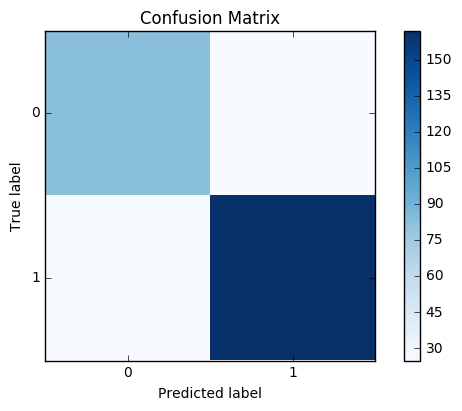

In [97]:
plot_confusion_matrix(clf, x_test, y_test)

## Train automatic model/hyperparameters selection

In [ ]:
#Models
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import linear_model, svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

from numpy.random import RandomState

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import sys
def concatenate(d1,d2):
    d = d1.copy()
    d.update(d2)
    return d
seed = 0

In [ ]:
sys.path.append('/Users/oarnaout/Dropbox/Stats/multiple-mets/')
import sklearnextensions as sklx
import printers

In [ ]:
# classifiers and parameters to consider
feature_parameters  = {
                'vect__binary':(False, True),
               'vect__ngram_range': ((1,1),(1,2),(1,3)),
               'vect__analyzer' : ('word', 'char_wb')}

nb_feature_parameters  = {'vect__ngram_range': ((1,1),(1,2),(1,3)),
               'vect__analyzer' : ('word', 'char_wb')}
use_spare_array = True
use_binary_features = True
classifiers = ({
    'logistic_regression':(linear_model.LogisticRegression(),
                           use_spare_array,
                           not use_binary_features,
                           concatenate(feature_parameters, {'clf__C': [1/x for x in [0.01, 0.1, 0.3, 1.0, 3.0, 10.0]]})),
    'svm_linear':(svm.LinearSVC(tol=1e-6),
                  use_spare_array,
                  not use_binary_features,
                  concatenate(feature_parameters, {'clf__C': [1/x for x in [0.01, 0.1, 0.3, 1.0, 3.0, 10.0]]})),
    'svm_gaussian':(svm.SVC(tol=1e-6, kernel='rbf'),
                    use_spare_array,
                    not use_binary_features,
                    concatenate(feature_parameters, {'clf__gamma': [.01, .03, 0.1],
                                             'clf__C': [1/x for x in [0.01, 0.1, 0.3, 1.0, 3.0, 10.0]]})),
    'decision_tree':(tree.DecisionTreeClassifier(criterion='entropy', random_state=RandomState(seed)),
                     not use_spare_array,
                     not use_binary_features,
                     concatenate(feature_parameters,{'clf__max_depth': [2, 3, 4, 5, 6, 7 , 8, 9, 10, 15, 20]})),
    'random_forest':(RandomForestClassifier(criterion='entropy', random_state=RandomState(seed)),
                     not use_spare_array,
                     not use_binary_features,
                     concatenate(feature_parameters,{'clf__max_depth': [2, 3, 4, 5],
                                                     'clf__n_estimators': [5, 25, 50, 100, 150, 200]})),
    'naive_bayes':(BernoulliNB(alpha=1.0, binarize=None, fit_prior=True, class_prior=None),
                   use_spare_array,
                   use_binary_features,
                   {'vect__ngram_range':((1,1),(1,2),(1,3)),
                    'vect__analyzer':('word', 'char_wb')})
})

In [ ]:
out_file = 'text.txt'

In [ ]:
best_accuracy = 0
for key, value in classifiers.items():
    clf = value[0] #classifier
    usa = value[1] #use sparse array
    ubf = value[2] #use binary (for NB)
    parameters = value[3]
    vectorizer = CountVectorizer(input='content', decode_error='ignore', preprocessor=None, binary=ubf)
    pipeline = (Pipeline(steps=[('vect', vectorizer),('clf',clf)]) if usa
                    else Pipeline(steps=[('vect', vectorizer),('sa',sklx.SparseToArray()),('clf',clf)]))
    gs = sklx.grid_analysis(pipeline, parameters, x_train, y_train)
    printers.print_grid_search_results(gs,key,out_file, x_test, y_test)
    if gs.best_score_>best_accuracy:
        final_clf = gs.best_estimator_
        best_accuracy = final_clf.score(x_test, y_test)

In [ ]:
best_accuracy

In [ ]:
# TODO: add model persistence to prevent re-training

# Web App

### Out of core learning (for partial fit hashing vect)

In [ ]:
import numpy as np
import re
from nltk.stem.porter import PorterStemmer

In [ ]:
def tokenizer_porter(text):
    text = re.sub('[\W]+', ' ', text.lower())
    tokenized = [porter.stem(word) for word in text]
    return tokenized

In [ ]:
def stream_docs(path):
    with open('train_dataOA7.19.16.csv', 'r') as csv:
        next(csv)
        for line in csv:
            text, label = line[2:-3], int(line[-2])
            yield text, label

In [ ]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
vect = HashingVectorizer(decode_error='ignore',
                        n_features=2**21,
                        preprocessor=None,
                        tokenizer=tokenizer_porter)

In [ ]:
clf = SGDClassifier(loss='log', random_state=1, n_iter=1)

In [ ]:
doc_stream = stream_docs(path='./train_dataOA7.19.16.csv')

In [ ]:
import pyprind

In [ ]:
pbar = pyprind.ProgBar(1)
classes = np.array([0,1])

In [ ]:
for _ in range (1):
    x_train, y_train = get_minibatch(doc_stream, size=170)
    if not x_train:
        break
    x_train = vect.transform(x_train)
    clf.partial_fit(x_train, y_train, classes=classes)
    pbar.update()

In [ ]:
len(y_train)

In [ ]:
x_test, y_test = get_minibatch(doc_stream, size=40)

In [ ]:
len(y_test)

In [ ]:
x_test = vect.transform(x_test)

In [ ]:
pred = clf.predict(x_test)

In [ ]:
print('Accuracy: %.3f' % clf.score(x_test, y_test))

In [ ]:
benchmark(clf, x_test, y_test)

In [ ]:
plot_confusion_matrix(clf, x_test, y_test)

In [ ]:
clf = clf.partial_fit(x_test, y_test)

## Serializing fitted scikit-learn estimators using pickle

In [ ]:
import pickle
import os

In [ ]:
dest = os.path.join('reportclassifier', 'pkl_objects')

In [ ]:
if not os.path.exists(dest):
    os.makedirs(dest)

In [ ]:
pickle.dump(stop, open(os.path.join(dest, 'stopwords.pkl'), 'wb'),
           protocol=2)

In [ ]:
pickle.dump(clf,
           open(os.path.join(dest, 'classifier.pkl'), 'wb'),
           protocol=2)